In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %cd /content/drive/MyDrive/Pipeline_HCM_AI/images

/content/drive/MyDrive/Pipeline_HCM_AI/images


## 1. Data processing
Những thông tin chúng ta có thể khai thác được:
- ảnh
- text
- audio
Những thông tin tạo ra được:
- OCR
- Object Name (Object Detection)
- Place (Place Recognition: bãi biển, rừng, sân vận động) => VLM lấy ra
- THời tiết (VLM lấy)
- ....
## Model
- CLIP
- EMbedding Ảnh
- Ebmedding Text (OCR, Object name, place,...) + Ảnh

## Faiss
- Thay đổi thuật toán tương đồng (đang mặc định cosine,....)


In [1]:
!gdown --id  1wVxIC52oJFbYt0FhN5tJealVj3YxuUBF

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1wVxIC52oJFbYt0FhN5tJealVj3YxuUBF
From (redirected): https://drive.google.com/uc?id=1wVxIC52oJFbYt0FhN5tJealVj3YxuUBF&confirm=t&uuid=31d3c6b7-c55a-4683-837d-cfaeea83bb7c
To: /content/images.zip
100% 106M/106M [00:03<00:00, 27.2MB/s]


In [ ]:
!unzip -q images.zip

replace images/L03_V001_L03_V001_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install -q faiss-cpu
!pip install -q git+https://github.com/openai/CLIP.git

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q translate
!pip install -q underthesea==1.3.5a3
!pip install -q underthesea[deep]
!pip install -q pyvi
!pip install -q langdetect
!pip install -q googletrans==3.1.0a0

In [ ]:
import os
import torch
import clip
from PIL import Image
import faiss
import numpy as np
import json
import matplotlib.pyplot as plt
import math
import googletrans
import translate
import glob
import underthesea
from pyvi import ViUtils, ViTokenizer
from difflib import SequenceMatcher
from langdetect import detect

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
features = []
id2img_fps = {}
list_image = glob.glob("images/*jpg")

# Đọc ảnh trong folder => CLIP => Embedding
for id, image_path in enumerate(list_image):
  id2img_fps[id] = image_path
  image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
  with torch.no_grad():
      image_features = model.encode_image(image).detach().cpu().numpy() # Lấy image embedding
      features.append(image_features) # Lưu embedding vào list

image_embeddings = np.concatenate(features) # list embedding

with open('image_path.json', 'w') as f:
  f.write(json.dumps(id2img_fps))

In [ ]:
# indexing
index = faiss.IndexFlatIP(image_embeddings.shape[1]) # method cosine: IndexFlatIP
index.add(image_embeddings)

In [ ]:
a = faiss.write_index(index, 'faiss_normal_ViT.bin')

In [ ]:
class Translation():
    def __init__(self, from_lang='vi', to_lang='en', mode='google'):
        # The class Translation is a wrapper for the two translation libraries, googletrans and translate.
        self.__mode = mode
        self.__from_lang = from_lang
        self.__to_lang = to_lang

        if mode in 'googletrans':
            self.translator = googletrans.Translator()
        elif mode in 'translate':
            self.translator = translate.Translator(from_lang=from_lang,to_lang=to_lang)

    def preprocessing(self, text):

        return text.lower()

    def __call__(self, text):

        text = self.preprocessing(text)
        return self.translator.translate(text) if self.__mode in 'translate' \
                else self.translator.translate(text, dest=self.__to_lang).text

class Text_Preprocessing():
    def __init__(self, stopwords_path='./dict/vietnamese-stopwords-dash.txt'):
        with open(stopwords_path, 'rb') as f:
            lines = f.readlines()
        self.stop_words = [line.decode('utf8').replace('\n','') for line in lines]

    def find_substring(self, string1, string2):

        match = SequenceMatcher(None, string1, string2, autojunk=False).find_longest_match(0, len(string1), 0, len(string2))
        return string1[match.a:match.a + match.size].strip()

    def remove_stopwords(self, text):

        text = ViTokenizer.tokenize(text)
        return " ".join([w for w in text.split() if w not in self.stop_words])

    def lowercasing(self, text):
        return text.lower()

    def uppercasing(self, text):
        return text.upper()

    def add_accents(self, text):

        return ViUtils.add_accents(u"{}".format(text))

    def remove_accents(self, text):

        return ViUtils.remove_accents(u"{}".format(text))

    def sentence_segment(self, text):

        return underthesea.sent_tokenize(text)

    def text_norm(self, text):

        return underthesea.text_normalize(text)

    def text_classify(self, text):

        return underthesea.classify(text)

    def sentiment_analysis(self, text):

        return underthesea.sentiment(text)

    def __call__(self, text):

        text = self.lowercasing(text)
        text = self.remove_stopwords(text)
        # text = self.remove_accents(text)
        # text = self.add_accents(text)
        text = self.text_norm(text)
        categories = self.text_classify(text)
        return categories


In [ ]:
class Myfaiss:
    def __init__(self, bin_file : str,id2img_fps, device, model):
        self.index= self.load_bin_file(bin_file)
        self.id2img_fps= id2img_fps
        self.device= device
        self.model= model

    def load_bin_file(self, bin_file: str):
        return faiss.read_index(bin_file)


    def show_images(self, image_paths):
        fig = plt.figure(figsize=(15, 10))
        columns = int(math.sqrt(len(image_paths)))
        rows = int(np.ceil(len(image_paths)/columns))

        for i in range(1, columns*rows +1):
          img = plt.imread(image_paths[i - 1])
          ax = fig.add_subplot(rows, columns, i)
          ax.set_title('/'.join(image_paths[i - 1].split('/')[-3:]))

          plt.imshow(img)
          plt.axis("off")

        plt.show()

    def image_search(self, id_query, k, bin_file):

        query_feats = self.index.reconstruct(id_query).reshape(1,-1)

        scores, idx_image = self.index.search(query_feats, k=k)
        idx_image = idx_image.flatten()

        infos_query = list(map(self.id2img_fps.get, list(idx_image)))
        image_paths = [info for info in infos_query]


        return scores, idx_image, infos_query, image_paths

    def text_search(self, text, k):
        translater= Translation()
        if detect(text) == 'vi':
            text = translater(text)

        ###### TEXT FEATURES EXACTING ######
        text = clip.tokenize([text]).to(device)
        text_features = model.encode_text(text).cpu().detach().numpy().astype(np.float32)

        ###### SEARCHING #####
        scores, idx_image = self.index.search(text_features, k=k)
        idx_image = idx_image.flatten()

        ###### GET INFOS KEYFRAMES_ID ######
        infos_query = list(map(self.id2img_fps.get, list(idx_image)))
        image_paths = [info for info in infos_query]

        return scores, idx_image, infos_query, image_paths

In [ ]:
bin_file='faiss_normal_ViT.bin'
faiss_test= Myfaiss(bin_file, id2img_fps, device, model)

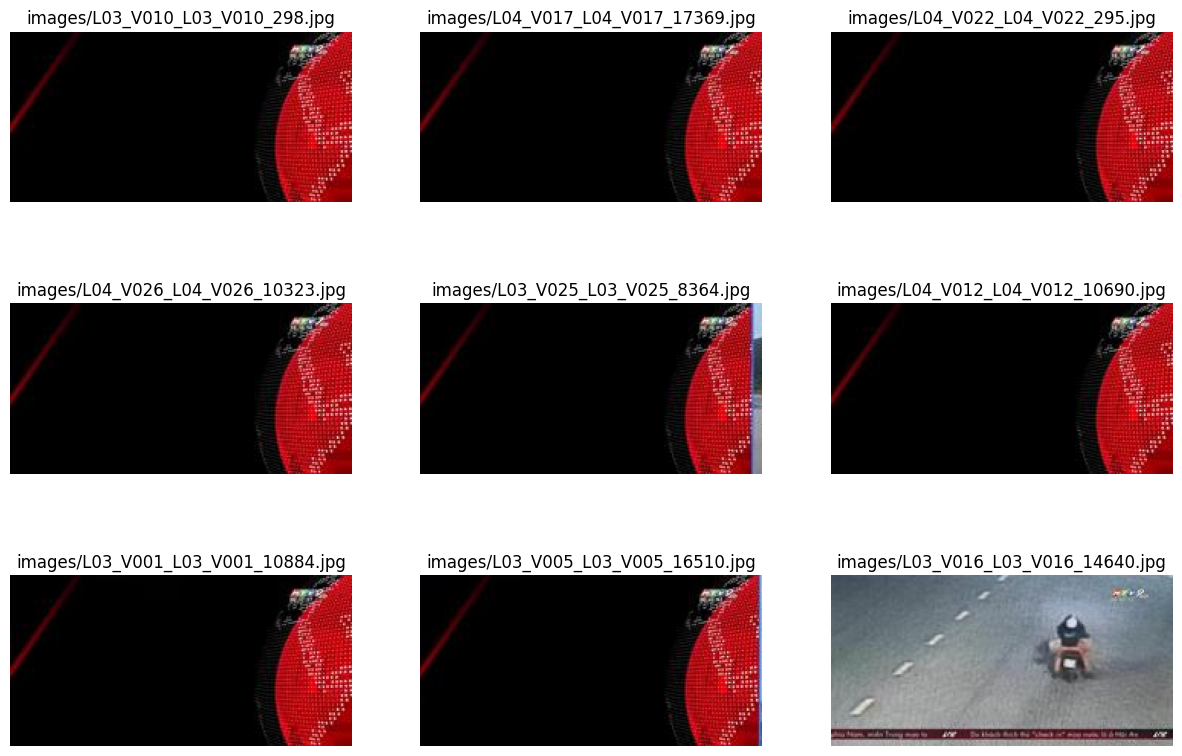

In [ ]:
text = 'một người'

scores, idx_image, infos_query, image_paths = faiss_test.text_search(text, k=9)
faiss_test.show_images(image_paths)